<a href="https://colab.research.google.com/github/simonzalan/vitmav45-nagyhazi/blob/main/VItmav45_Nagyhazi_3_milestone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Getting image datasets from the MVTEC website

In [ ]:
import os
os.system("wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz -O mvtec_anomaly_detection.tar.xz")
os.system("tar -xf mvtec_anomaly_detection.tar.xz")

0

In [ ]:
import os
!ls /content/carpet/train/good
os.system("mkdir mappa")
!ls /

000.png  032.png  064.png  096.png  128.png  160.png  192.png  224.png	256.png
001.png  033.png  065.png  097.png  129.png  161.png  193.png  225.png	257.png
002.png  034.png  066.png  098.png  130.png  162.png  194.png  226.png	258.png
003.png  035.png  067.png  099.png  131.png  163.png  195.png  227.png	259.png
004.png  036.png  068.png  100.png  132.png  164.png  196.png  228.png	260.png
005.png  037.png  069.png  101.png  133.png  165.png  197.png  229.png	261.png
006.png  038.png  070.png  102.png  134.png  166.png  198.png  230.png	262.png
007.png  039.png  071.png  103.png  135.png  167.png  199.png  231.png	263.png
008.png  040.png  072.png  104.png  136.png  168.png  200.png  232.png	264.png
009.png  041.png  073.png  105.png  137.png  169.png  201.png  233.png	265.png
010.png  042.png  074.png  106.png  138.png  170.png  202.png  234.png	266.png
011.png  043.png  075.png  107.png  139.png  171.png  203.png  235.png	267.png
012.png  044.png  076.png  108.png  140.png  172.png

Installing library for easy splitting of the downloaded dataset

In [ ]:
os.system("pip install split-folders")

0

Creating a validation image batch from the training batch

In [ ]:

import splitfolders
splitfolders.ratio("/content/carpet/train", output="output1", seed=1337, ratio=(.9,0.1)) 

Copying files: 280 files [00:03, 71.75 files/s]


Checking if the images are in their places

In [ ]:
os.system("ls /content/output1/train/good")


0

Testing if the images are where they need to be

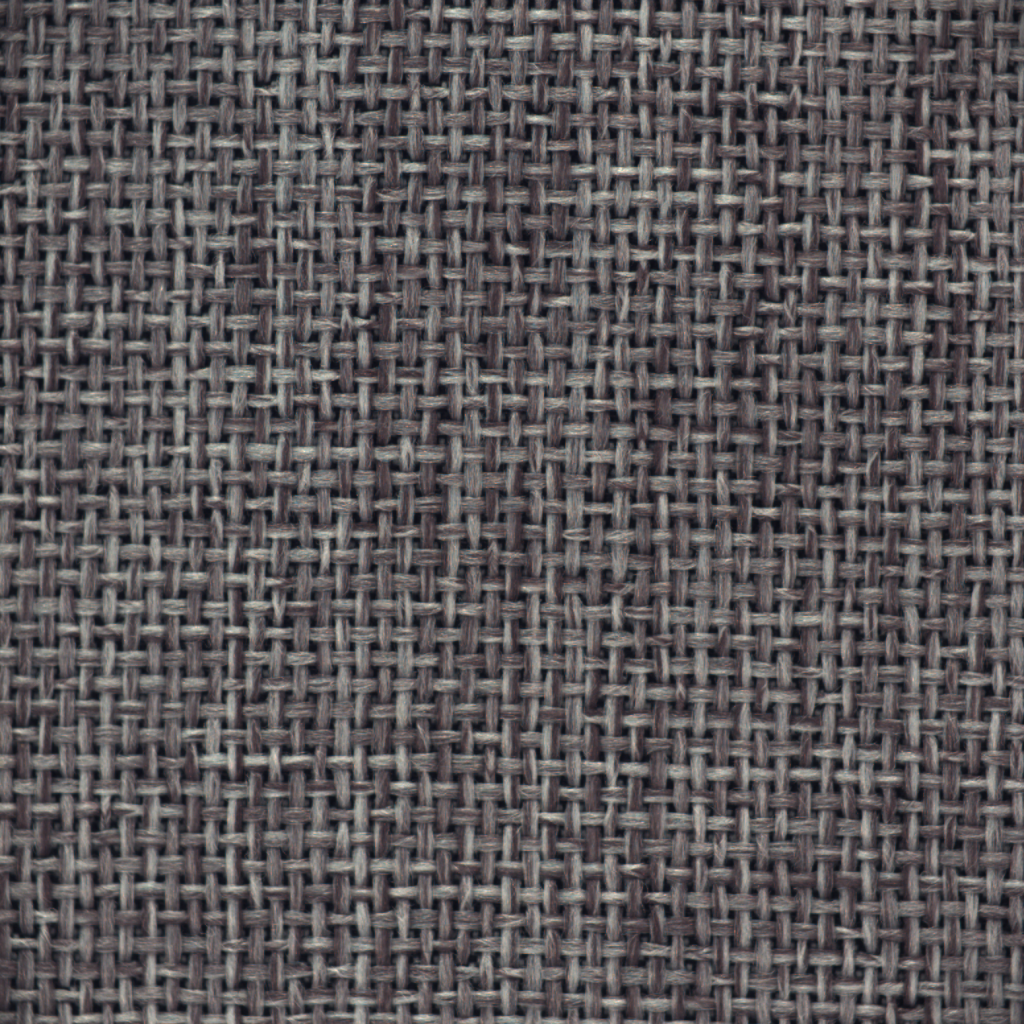

In [ ]:
from IPython.display import Image
Image("/content/carpet/train/good/009.png")


Importing libraries that will be used later

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, UpSampling2D, BatchNormalization, Conv2DTranspose
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Loading the images into variables(training, testinf and validation)

In [ ]:
image_size = 512
batch_size = 16

datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    '/content/output1/train/',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    '/content/output1/val/',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = datagen.flow_from_directory(
    '/content/carpet/test/',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='input'
    )

train_ds = image_dataset_from_directory("/content/output1/train/", 
                                        label_mode='categorical',
                                        image_size=(image_size, image_size),
                                        batch_size=batch_size)
val_ds = image_dataset_from_directory("/content/output1/val/",
                                      label_mode='categorical',
                                      image_size=(image_size, image_size),
                                      batch_size=batch_size)
test_ds = image_dataset_from_directory("/content/carpet/test/",
                                      label_mode='categorical',
                                      image_size=(image_size, image_size),
                                      batch_size=batch_size)



Found 252 images belonging to 1 classes.
Found 28 images belonging to 1 classes.
Found 117 images belonging to 6 classes.
Found 252 files belonging to 1 classes.
Found 28 files belonging to 1 classes.
Found 117 files belonging to 6 classes.


Checking if the images are all the same size

In [ ]:
from PIL import Image
import os.path

files = os.listdir("/content/output1/val/good/")
same_size = True
for f in files:
    filename = "/content/output1/val/good/" + f
    im = Image.open(filename)
    #print(im.size)
    if im.size != (1024, 1024):
        print("NOT OK")
        same_size = False

print(same_size)
print(train_ds.snapshot)




True
<bound method DatasetV2.snapshot of <BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>>


Encoder and Decoder


In [ ]:
#Encoder
model = Sequential()
model.add(Conv2D(128, (2,2), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(128, (2,2), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(64, (2,2), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (2,2), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))






#Decoder



model.add(Conv2DTranspose(32, (2,2), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2DTranspose(64, (2,2), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2DTranspose(128, (2,2), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2DTranspose(128, (2,2), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2DTranspose(3, (2,2), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 128)     1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 128)     65664     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 128)    0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      32832     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 64)       0

Fitting the model

In [ ]:

history = model.fit(
        train_generator,
        steps_per_epoch= 250 // batch_size,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=32 // batch_size,
        shuffle = True)

Epoch 1/100
15/15 [==============================] - 32s 1s/step - loss: 0.0248 - mse: 0.0248 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 2/100
15/15 [==============================] - 18s 1s/step - loss: 0.0197 - mse: 0.0197 - val_loss: 0.0199 - val_mse: 0.0199
Epoch 3/100
15/15 [==============================] - 19s 1s/step - loss: 0.0193 - mse: 0.0193 - val_loss: 0.0198 - val_mse: 0.0198
Epoch 4/100
15/15 [==============================] - 18s 1s/step - loss: 0.0191 - mse: 0.0191 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 5/100
15/15 [==============================] - 18s 1s/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0195 - val_mse: 0.0195
Epoch 6/100
15/15 [==============================] - 18s 1s/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0197 - val_mse: 0.0197
Epoch 7/100
15/15 [==============================] - 18s 1s/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 8/100
15/15 [==============================] - 18s 1s/step - loss: 0.0189 - m

Plot the training and validation accuracy and loss at each epoch

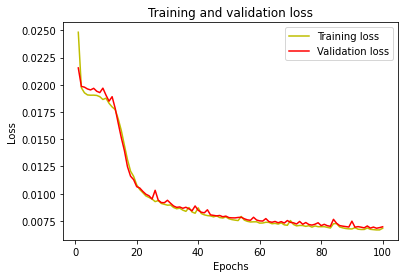

In [ ]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Get all batches generated by the datagen and pick a batch for prediction

In [ ]:

data_batch = []
img_num = 0
while img_num <= train_generator.batch_index:   
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0])  

1/1 [==============================] - 0s 234ms/step


View few images and corresponding reconstructions

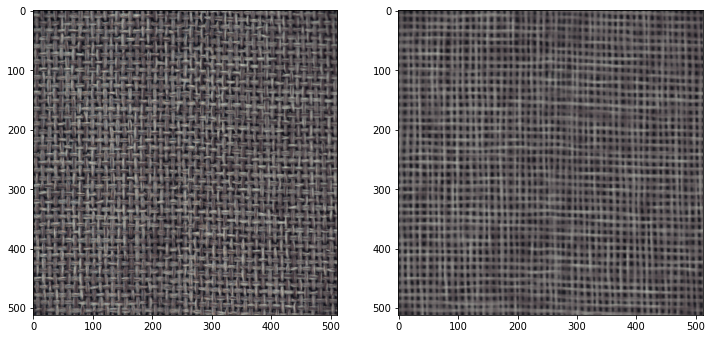

In [ ]:

image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

Examine the reconstruction error between our validation data (good/normal images) and the anomaly images

In [ ]:

validation_error = model.evaluate_generator(validation_generator)
anomaly_error = model.evaluate_generator(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

<ipython-input-15-e39292c457be>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  validation_error = model.evaluate_generator(validation_generator)
<ipython-input-15-e39292c457be>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  anomaly_error = model.evaluate_generator(anomaly_generator)


Recon. error for the validation (normal) data is:  [0.0069589922204613686, 0.0069589922204613686]
Recon. error for the anomaly data is:  [0.007537884172052145, 0.007537884172052145]


Let us extract (or build) the encoder network, with trained weights.This is used to get the compressed output (latent space) of the input image. The compressed output is then used to calculate the KDE

In [ ]:


encoder_model = Sequential()

encoder_model.add(Conv2D(128, (2,2), activation='relu', padding='same', input_shape=(image_size, image_size, 3), weights=model.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(128, (2,2), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(64, (2,2), activation='relu', padding='same', weights=model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (2,2), activation='relu', padding='same', weights=model.layers[6].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))


encoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 512, 512, 128)     1664      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 256, 256, 128)    0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 128)     65664     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 128)    0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      32832     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 64)      

In [ ]:
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict_generator(train_generator)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

<ipython-input-17-bd7cf74ec2f6>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  encoded_images = encoder_model.predict_generator(train_generator)


Calculate density and reconstruction error to find their means values forgood and anomaly images. We use these mean and sigma to set thresholds. 

In [ ]:

def calc_density_and_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) 
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
        density = kde.score_samples(encoded_img)[0] 
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_density, stdev_density, average_recon_error, stdev_recon_error

Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images. 
For this let us generate a batch of images for each. 

In [ ]:

train_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

uninfected_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)


1/1 [==============================] - 0s 42ms/step - loss: 0.0080 - mse: 0.0080


In [ ]:
import PIL
import cv2
from google.colab.patches import cv2_imshow

Subtracts 2 images

In [ ]:
def mse(img1, img2):
   h, w = img1.shape
   diff = cv2.subtract(img1, img2)
   err = np.sum(diff**2)
   mse = err/(float(h*w))
   return mse, diff

Shows the anomyaly spot

In [ ]:
def show_anomaly(img,reconstructed):

  pil_image = np.array(img.resize((512,512)))
  open_cv_image = np.array(pil_image) 
  # Convert RGB to BGR 
  open_cv_image = open_cv_image[:, :, ::-1].copy() 
  img1 = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
  img1 = np.asarray(img1, np.float32)

  reconstructed = np.array(reconstructed) 
  reconstructed = reconstructed[:, :, ::-1].copy()
  img2 = cv2.cvtColor(reconstructed, cv2.COLOR_BGR2GRAY)
  error, diff = mse(img2, img1)
  print("Image matching Error between the two images:", error)
  cv2_imshow( img2)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
 


Input unknown images and sort as Good or Anomaly

In [ ]:

def check_anomaly(img_path):
    density_threshold = 20000
    reconstruction_error_threshold = 0.015 
    img  = PIL.Image.open(img_path)
    img = np.array(img.resize((512,512), PIL.Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    show_anomaly(PIL.Image.open(img_path).convert('RGB'),reconstruction[0])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
    
    if density > density_threshold or reconstruction_error > reconstruction_error_threshold:
        print(reconstruction_error)
        print(density)
        print("The image is an anomaly")
        
    else:
        print("The image is NOT an anomaly")
        print(reconstruction_error)
        print(density)

Load a couple of test images and verify whether they are reported as anomalies

In [ ]:

import glob
para_file_paths = glob.glob('/content/carpet/test/hole/*')
uninfected_file_paths = glob.glob('/content/carpet/test/good/*')


Anomaly image verification

1/1 [==============================] - 0s 17ms/step
Image matching Error between the two images: 9730.8935546875


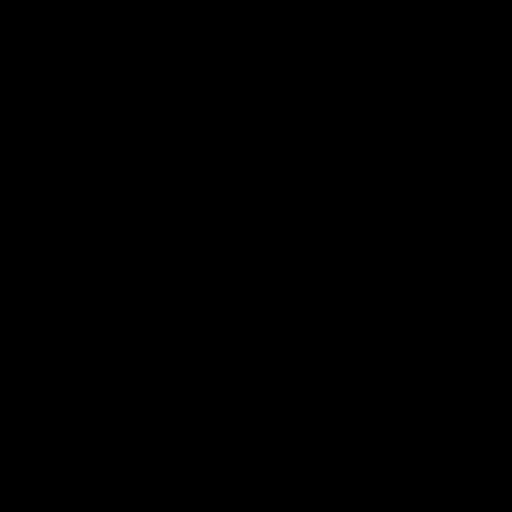

1/1 [==============================] - 0s 41ms/step - loss: 0.0080 - mse: 0.0080
0.008000947535037994
22586.7786799661
The image is an anomaly


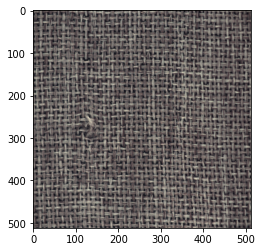

In [ ]:

num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])

Good/normal image verification

1/1 [==============================] - 0s 44ms/step - loss: 0.0071 - mse: 0.0071
The image is NOT an anomaly
0.007137458771467209
16248.985827964649


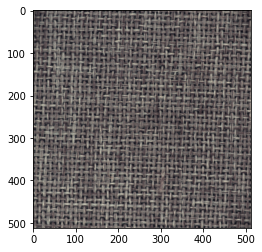

In [ ]:

num=random.randint(0,len(para_file_paths)-1)
check_anomaly(uninfected_file_paths[num])